# Emotion Analysis

Using pyTorch

In [0]:
#support both Python 2 and Python 3 with minimal overhead.
from __future__ import absolute_import, division, print_function

# I am an engineer. I care only about error not warning. So, let's be maverick and ignore warnings.
import warnings
warnings.filterwarnings('ignore')

In [0]:
# For data processing and maths
import numpy as np
import pandas as pd
import time
#For Visuals
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from matplotlib import rcParams
rcParams['figure.figsize'] = 11, 8
%config InlineBackend.figure_format = 'svg'
%matplotlib inline

In [0]:
# for ML tasks and text preprocessing

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import itertools
import pandas as pd
from scipy import stats
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder

In [0]:
# import torch 
import torch
import torch.nn as nn

In [0]:
import pickle

def convert_to_pickle(item, directory):
    pickle.dump(item, open(directory,"wb"))


def load_from_pickle(directory):
    return pickle.load(open(directory,"rb"))

In [42]:
! pip install version_information

In [43]:
# first install: pip install version_information
%reload_ext version_information
%version_information pandas,torch,numpy,seaborn, matplotlib

Software versions
Python 3.6.8 64bit [GCC 8.0.1 20180414 (experimental) [trunk revision 259383]
IPython 5.5.0
OS Linux 4.14.137+ x86_64 with Ubuntu 18.04 bionic
pandas 0.24.2
torch 1.2.0
numpy 1.16.5
seaborn 0.9.0
matplotlib 3.0.3
Fri Oct 18 15:23:09 2019 UTC

# 2)- Loading data

Thanks to PyCon 2019 : https://github.com/omarsar/nlp_pycon

In [0]:
data=pd.read_pickle('merged_training.pkl')

In [45]:
data.shape

(416809, 2)

In [46]:
data.head()

,text,emotions
27383,i feel awful about it too because it s my job ...,sadness
110083,im alone i feel awful,sadness
140764,ive probably mentioned this before but i reall...,joy
100071,i was feeling a little low few days back,sadness
2837,i beleive that i am much more sensitive to oth...,love


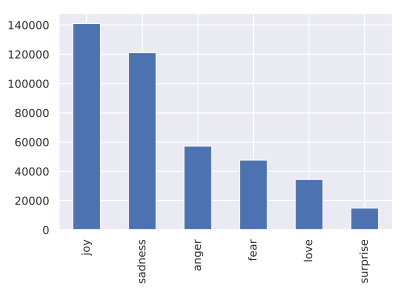

In [47]:
data.emotions.value_counts().plot(kind='bar')

# 3)-Preprocessing

- a)- Tokenize
- b)-Sampling
- c)-Vocab Building
- d)- Tensor Conversion
- e)-Padding

### a)-tokenize

In [0]:
data['token']=data['text'].apply(lambda x:x.split(' '))

In [49]:
data.head()

,text,emotions,token
27383,i feel awful about it too because it s my job ...,sadness,"[i, feel, awful, about, it, too, because, it, ..."
110083,im alone i feel awful,sadness,"[im, alone, i, feel, awful]"
140764,ive probably mentioned this before but i reall...,joy,"[ive, probably, mentioned, this, before, but, ..."
100071,i was feeling a little low few days back,sadness,"[i, was, feeling, a, little, low, few, days, b..."
2837,i beleive that i am much more sensitive to oth...,love,"[i, beleive, that, i, am, much, more, sensitiv..."


In [50]:
data["token_size"] = data["text"].apply(lambda x: len(x.split(' ')))
data.head()

,text,emotions,token,token_size
27383,i feel awful about it too because it s my job ...,sadness,"[i, feel, awful, about, it, too, because, it, ...",26
110083,im alone i feel awful,sadness,"[im, alone, i, feel, awful]",5
140764,ive probably mentioned this before but i reall...,joy,"[ive, probably, mentioned, this, before, but, ...",27
100071,i was feeling a little low few days back,sadness,"[i, was, feeling, a, little, low, few, days, b...",9
2837,i beleive that i am much more sensitive to oth...,love,"[i, beleive, that, i, am, much, more, sensitiv...",18


In [51]:
data.shape

(416809, 4)

In [0]:
# Limiting size to avoid too much padding
data = data.loc[data['token_size'] < 70].copy()

In [53]:
data.shape

(416789, 4)

Notice how we have reduced our samples as we are only taking token size < 70

### b)- sampling

In [54]:
data = data.sample(n=50000);

data.head()

,text,emotions,token,token_size
94460,i think im just feeling gloomy for having a qu...,sadness,"[i, think, im, just, feeling, gloomy, for, hav...",14
18165,i didnt feel mentally miserable at times as we...,sadness,"[i, didnt, feel, mentally, miserable, at, time...",14
7602,i feel about what is and is not the more compa...,love,"[i, feel, about, what, is, and, is, not, the, ...",29
15538,i could feel my toes going numb then on up my ...,sadness,"[i, could, feel, my, toes, going, numb, then, ...",15
48740,i feel like instagram gives people an opportun...,joy,"[i, feel, like, instagram, gives, people, an, ...",17


We could also use shuffle to do randomly select our sample. This random selection will reduce possibility of selection biasness in our data.

### c)- Vocab building

After tokenizing text, it's time to build the vocabulary, which is used to determine the features that we will be using to train the models.

In [0]:
# This class creates a word -> index mapping (e.g,. "dad" -> 5) and vice-versa 
# (e.g., 5 -> "dad") for the dataset
class ConstructVocab():
    def __init__(self, sentences):
        self.sentences = sentences
        self.word2idx = {}
        self.idx2word = {}
        self.vocab = set()
        self.create_index()
        
    def create_index(self):
        for s in self.sentences:
            # update with individual tokens
            self.vocab.update(s.split(' '))
            
        # sort the vocab
        self.vocab = sorted(self.vocab)

        # add a padding token with index 0
        self.word2idx['<pad>'] = 0
        
        # word to index mapping
        for index, word in enumerate(self.vocab):
            self.word2idx[word] = index + 1 # +1 because of pad token
        
        # index to word mapping
        for word, index in self.word2idx.items():
            self.idx2word[index] = word  

In [0]:
# construct vocab and indexing
inputs = ConstructVocab(data["text"].values.tolist())

In [57]:
type(inputs)

__main__.ConstructVocab

In [58]:
# examples of what is in the vocab
inputs.vocab[0:10]

['a',
 'aa',
 'aaa',
 'aaaaall',
 'aac',
 'aaradhya',
 'aaron',
 'aart',
 'aarthi',
 'ab']

### d)-Converting Data Into Tensors

In [0]:
# vectorize to tensor
input_tensor = [[inputs.word2idx[s] for s in es.split(' ')]  for es in data["text"].values.tolist()]

In [60]:
# examples of what is in the input tensors
input_tensor[0:2]

[[11590,
  24203,
  11718,
  13043,
  8680,
  10023,
  9211,
  10821,
  1,
  19050,
  23084,
  7022,
  14910,
  13499],
 [11590,
  6465,
  8673,
  14925,
  15203,
  1466,
  24389,
  1343,
  26453,
  13043,
  16246,
  684,
  24114,
  24382]]

In [61]:
type(input_tensor)

list

### e)-Padding Data
In order to train our recurrent neural network , it is required padding to generate inputs of same length.

In [0]:
def max_length(tensor):
    return max(len(t) for t in tensor)

In [63]:
# calculate the max_length of input tensor
max_length_inp = max_length(input_tensor)
print(max_length_inp)

69


In [0]:
import numpy as np

def pad_sequences(x, max_len):
    padded = np.zeros((max_len), dtype=np.int64)
    if len(x) > max_len: padded[:] = x[:max_len]
    else: padded[:len(x)] = x
    return padded

In [0]:
# inplace padding
input_tensor = [pad_sequences(x, max_length_inp) for x in input_tensor]

In [67]:
input_tensor[0:2]

[array([11590, 24203, 11718, 13043,  8680, 10023,  9211, 10821,     1,
        19050, 23084,  7022, 14910, 13499,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0]),
 array([11590,  6465,  8673, 14925, 15203,  1466, 24389,  1343, 26453,
        13043, 16246,   684, 24114, 24382,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,    

All these extra zero are making matrix of our interest as of same length. Hence, padding is important before modeling.

**Our input is ready for model. But, we need to look at target feature as well**

# 4)- Target Variable

In [68]:
data.emotions.value_counts()

joy         16826
sadness     14519
anger        6881
fear         5810
love         4189
surprise     1775
Name: emotions, dtype: int64

In [0]:
# convert targets to one-hot encoding vectors
emotions = list(set(data.emotions.unique()))
num_emotions = len(emotions)

In [71]:
emotions

['joy', 'love', 'sadness', 'surprise', 'fear', 'anger']

In [72]:
num_emotions

6

In [0]:
# binarizer
mlb = preprocessing.MultiLabelBinarizer()
data_labels =  [set(emos) & set(emotions) for emos in data[['emotions']].values]
bin_emotions = mlb.fit_transform(data_labels)
target_tensor = np.array(bin_emotions.tolist())

In [76]:
target_tensor

array([[0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0, 0],
       ...,
       [0, 0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0]])

In [0]:
get_emotion = lambda t: np.argmax(t)

In [78]:
get_emotion(target_tensor[0])

4

In [0]:
emotion_dict = {0: 'anger', 1: 'fear', 2: 'joy', 3: 'love', 4: 'sadness', 5: 'surprise'}

In [80]:
emotion_dict[get_emotion(target_tensor[0])]

'sadness'

### 4.2)- Splitting data into train and validation set

In [81]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Split the validataion further to obtain a holdout dataset (for testing) -- split 50:50
input_tensor_val, input_tensor_test, target_tensor_val, target_tensor_test = train_test_split(input_tensor_val, target_tensor_val, test_size=0.5)

# Show length
len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val), len(input_tensor_test), len(target_tensor_test)

(40000, 40000, 5000, 5000, 5000, 5000)

### 4.3)-Dataset and Data Loader
We can also laod the data into a data loader, which makes it easy to manipulate the data, create batches, and apply further transformations. In PyTorch we can use the DataLoader function.

In [0]:
TRAIN_BUFFER_SIZE = len(input_tensor_train)
VAL_BUFFER_SIZE = len(input_tensor_val)
TEST_BUFFER_SIZE = len(input_tensor_test)
BATCH_SIZE = 64

TRAIN_N_BATCH = TRAIN_BUFFER_SIZE // BATCH_SIZE
VAL_N_BATCH = VAL_BUFFER_SIZE // BATCH_SIZE
TEST_N_BATCH = TEST_BUFFER_SIZE // BATCH_SIZE

In [0]:
from torch.utils.data import Dataset, DataLoader

In [0]:
class MyData(Dataset):
    def __init__(self, X, y):
        self.data = X
        self.target = y
        self.length = [ np.sum(1 - np.equal(x, 0)) for x in X]
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        x_len = self.length[index]
        return x, y, x_len
    
    def __len__(self):
        return len(self.data)

In [0]:
# Data instance
train_dataset = MyData(input_tensor_train, target_tensor_train)
val_dataset = MyData(input_tensor_val, target_tensor_val)
test_dataset = MyData(input_tensor_test, target_tensor_test)


# Data Loader instance
train_dataset = DataLoader(train_dataset, batch_size = BATCH_SIZE, 
                     drop_last=True,
                     shuffle=True)

val_dataset = DataLoader(val_dataset, batch_size = BATCH_SIZE, 
                     drop_last=True,
                     shuffle=True)

test_dataset = DataLoader(test_dataset, batch_size = BATCH_SIZE, 
                     drop_last=True,
                     shuffle=True)

In [86]:
val_dataset.batch_size

64

In [87]:
train_dataset.batch_size

64

In [88]:
test_dataset.batch_size

64

In [89]:
num_emotions

6

### 4.4)-Store the Data for Reuse

In [0]:
data_folder = "Data"
convert_to_pickle(train_dataset, data_folder + "train_dataset")
convert_to_pickle(val_dataset, data_folder + "val_dataset")
convert_to_pickle(test_dataset, data_folder + "test_dataset")

In [0]:
# Helper functions
import pickle

def convert_to_pickle(item, directory):
    pickle.dump(item, open(directory,"wb"))


def load_from_pickle(directory):
    return pickle.load(open(directory,"rb"))